# Bitcoin Prediction Using ARIMA and RNN-LSTM
## Please refer to the project report for details on results and observations

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn; seaborn.set()
import datetime
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation
import seaborn as sns
sns.set()
%load_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.imports import *
# from fastai.structured import *
from fastai.tabular import *
from fastai.tabular.all import *
# from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

Download all the files and Read all the files

In [3]:
# %sc !wget 'https://s3.amazonaws.com/sagemakermathan/bitstamp.csv'
# %sc !wget 'https://s3.amazonaws.com/sagemakermathan/coinbase.csv'
# %sc !wget 'https://s3.amazonaws.com/sagemakermathan/cryptonewskaggle.csv'
# %sc !wget 'https://s3.amazonaws.com/sagemakermathan/news.csv'
# %sc !wget 'https://s3.amazonaws.com/sagemakermathan/cryptonewskagglecleaned.csv'

In [4]:
coinbase=pd.read_csv('coinbase.csv')
# cryptonewsonly=pd.read_csv('cryptonewscleanedallmagic.csv',encoding='iso-8859-1')

## Preprocessing Please look more for util Notebook

## Data Exploration

In [5]:
coinbase.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0


In [7]:
coinbase.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,1.574274e+06,1.574274e+06,1.574274e+06,1.574274e+06,1.574274e+06,1.574274e+06,1.574274e+06,1.574274e+06
mean,1.468131e+09,1.705118e+03,1.706025e+03,1.704113e+03,1.705123e+03,7.073412e+00,2.267928e+04,1.705069e+03
std,2.728500e+07,3.059038e+03,3.061434e+03,3.056505e+03,3.059105e+03,1.698569e+01,1.225156e+05,3.058976e+03
min,1.417412e+09,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08,2.641700e-06,6.000000e-02
25%,1.444527e+09,2.903000e+02,2.904100e+02,2.901800e+02,2.903000e+02,6.915000e-01,3.162361e+02,2.903031e+02
50%,1.468141e+09,5.900500e+02,5.902100e+02,5.899800e+02,5.900200e+02,2.381500e+00,1.398624e+03,5.900207e+02
75%,1.491756e+09,1.224490e+03,1.224810e+03,1.224090e+03,1.224490e+03,7.032457e+00,7.601787e+03,1.224453e+03
max,1.515370e+09,1.989199e+04,1.989199e+04,1.989198e+04,1.989199e+04,1.563267e+03,1.997076e+07,1.989199e+04


In [8]:
# cryptonewsonly.describe()

In [9]:
coinbase.isna().sum()/coinbase.count()

Timestamp            0.0
Open                 0.0
High                 0.0
Low                  0.0
Close                0.0
Volume_(BTC)         0.0
Volume_(Currency)    0.0
Weighted_Price       0.0
dtype: float64

First of First, I feel timestamp values are not humanly readable so let's convert it into a normal date first

In [10]:
def timestampToDateTime(timestamp):
    from datetime import datetime
    return datetime.fromtimestamp(timestamp)

coinbase['Date']=coinbase['Timestamp'].apply(timestampToDateTime)

In [11]:
coinbase.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:33:00
1,1417412040,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:34:00
2,1417412100,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:35:00
3,1417412160,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:36:00
4,1417412220,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:37:00


Let's get rid of the timestamp Now

In [12]:
coinbase.drop('Timestamp',axis=1,inplace=True) 

Let's verify if everything looks good

In [13]:
coinbase.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
0,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:33:00
1,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:34:00
2,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:35:00
3,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:36:00
4,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 00:37:00


In [14]:
coinbase[coinbase['Date']=='2016']

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
511853,436.12,436.13,436.12,436.13,1.4387,627.460131,436.12993,2016-01-01


To fetch all the data for a year, we need to first index the dataframe by date and then we can query intresting things and explore the data more. This is pretty common in time series analysis and useful for data exploration too.

In [15]:
timeindex=pd.DatetimeIndex(coinbase['Date'])

In [16]:
coinbase.set_index(timeindex,inplace=True)

As you can see now we can fetch data with respect to a particular date. Let's do some exploration now! 

In [17]:
coinbase['2016-01-21'].head()

<ipython-input-17-fa20f238523a>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  coinbase['2016-01-21'].head()


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date
Date,,,,,,,,
2016-01-21 00:00:00,414.57,414.59,414.54,414.59,21.464480,8898.054200,414.547858,2016-01-21 00:00:00
2016-01-21 00:01:00,414.56,414.56,414.27,414.27,6.672710,2766.101840,414.539496,2016-01-21 00:01:00
2016-01-21 00:02:00,414.24,414.24,414.00,414.00,8.210732,3399.333643,414.011022,2016-01-21 00:02:00
2016-01-21 00:03:00,414.00,414.01,414.00,414.01,1.620680,670.972006,414.006470,2016-01-21 00:03:00
2016-01-21 00:04:00,414.00,414.01,413.55,413.55,42.184428,17453.142163,413.734233,2016-01-21 00:04:00


Just to confirm that the dataset is a legitimate one, we plot the bitcoin values for year 2017-18 and as we know that the spike in the market we can confirm that the dataset is legitimate.

In [18]:
# #sns.set(style="darkgrid")
# import seaborn as sns; sns.set()
# #sns.lineplot(x="Date", y="Close",
# #             data=coinbase)
# coinbase['2017':'2018']['High'].resample(rule='T').plot()

Time to learn new things

<ipython-input-19-69aa7b0f3776>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data=coinbase['2017-07-02']


Date
2017-07-31    AxesSubplot(0.125,0.11;0.775x0.77)
Freq: BM, Name: High, dtype: object

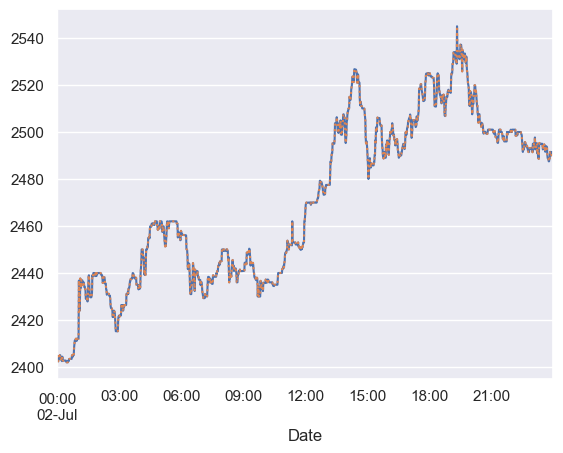

In [19]:
data=coinbase['2017-07-02']
data['High'].plot(style="-")
data['High'].resample('BM').plot(style=":")

 Notice the difference: at each point, resample reports the average of the previous year, while asfreq reports the value at the end of the year. You can resample by hour, minutes, years, days etc. This indeed is a convenient tool."

In [20]:
def preprocess(dataframe):
    data=data.fillna(method='ffill')
    data=add_datepart(data, 'Date')
    return data

As we noticed there are few NAN values and we dont want to drop those values. Since it is a time series data, we need to be extremely careful how we handle these values.
There are two options:
1. Fill the missing values with previous values (forward fill)
2. Fill the missing values with future values (backward fill)

We choose forward Fill

In [21]:
coinbase=coinbase.fillna(method='ffill')

The most basic form of analysis: Let's find the co-relation and see if we can find anything useful. Nothing intresting as all the features are computed from each other.

In [22]:
coinbase.corr()

<ipython-input-22-6f0edc0a89c4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  coinbase.corr()


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Open,1.000000,0.999997,0.999997,0.999996,0.204421,0.497802,0.999999
High,0.999997,1.000000,0.999994,0.999998,0.204978,0.498775,0.999998
Low,0.999997,0.999994,1.000000,0.999997,0.203783,0.496770,0.999998
Close,0.999996,0.999998,0.999997,1.000000,0.204399,0.497814,0.999999
Volume_(BTC),0.204421,0.204978,0.203783,0.204399,1.000000,0.575376,0.204366
Volume_(Currency),0.497802,0.498775,0.496770,0.497814,0.575376,1.000000,0.497755
Weighted_Price,0.999999,0.999998,0.999998,0.999999,0.204366,0.497755,1.000000


We predict the price for the bitcoin after 2 days in this case. Therefore we need to prepare the dataframe with input row as todays price and predictor as price after 2 days. 

In [23]:
coinbase['PriceClose2D']=coinbase['Close']

In [24]:
shift=24 # 24 hours = 2days 
coinbase['PriceClose2D']=coinbase['PriceClose2D'].shift(-shift)
coinbase=coinbase[:-shift]

In [25]:
coinbase[73:90]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date,PriceClose2D
Date,,,,,,,,,
2014-12-01 01:46:00,370.0,370.0,370.0,370.0,0.010000,3.70000,370.0,2014-12-01 01:46:00,370.0
2014-12-01 01:47:00,370.0,370.0,370.0,370.0,0.010000,3.70000,370.0,2014-12-01 01:47:00,370.0
2014-12-01 01:48:00,370.0,370.0,370.0,370.0,0.010000,3.70000,370.0,2014-12-01 01:48:00,370.0
2014-12-01 01:49:00,370.0,370.0,370.0,370.0,0.010000,3.70000,370.0,2014-12-01 01:49:00,370.0
2014-12-01 01:50:00,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0,2014-12-01 01:50:00,370.0
2014-12-01 01:51:00,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0,2014-12-01 01:51:00,370.0
2014-12-01 01:52:00,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0,2014-12-01 01:52:00,370.0
2014-12-01 01:53:00,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0,2014-12-01 01:53:00,370.0
2014-12-01 01:54:00,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0,2014-12-01 01:54:00,370.0


Now inorder to capture temporal features for very basic algorithms we add date time features dervied from datetime like isweekday,
is weekday, is public holiday etc to capture seasonal trends which we will cover in detail in a minute.

In [26]:
add_datepart(coinbase,'Date')

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,PriceClose2D,Year,Month,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-01 00:33:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
2014-12-01 00:34:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
2014-12-01 00:35:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
2014-12-01 00:36:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
2014-12-01 00:37:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-07 18:32:00,16349.00,16349.00,16329.00,16329.00,4.303270,70338.446619,16345.349090,16174.23,2018,1,...,7,6,7,False,False,False,False,False,False,1.515350e+09
2018-01-07 18:33:00,16329.01,16329.01,16300.00,16302.85,8.183248,133574.283340,16322.892267,16174.22,2018,1,...,7,6,7,False,False,False,False,False,False,1.515350e+09
2018-01-07 18:34:00,16302.84,16302.84,16279.74,16279.74,7.083056,115426.384420,16296.128527,16174.21,2018,1,...,7,6,7,False,False,False,False,False,False,1.515350e+09


In [27]:
coinbase['2015']

<ipython-input-27-2868ae9b1f97>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  coinbase['2015']


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,PriceClose2D,Year,Month,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07 20:24:00,360.00,360.00,360.00,360.00,0.010000,3.600000,360.000000,317.98,2015,1,...,7,2,7,False,False,False,False,False,False,1.420662e+09
2015-01-07 20:25:00,360.00,360.00,360.00,360.00,0.010000,3.600000,360.000000,301.99,2015,1,...,7,2,7,False,False,False,False,False,False,1.420662e+09
2015-01-07 20:26:00,360.00,360.00,360.00,360.00,0.010000,3.600000,360.000000,333.28,2015,1,...,7,2,7,False,False,False,False,False,False,1.420662e+09
2015-01-07 20:27:00,271.84,276.34,271.84,276.34,0.020000,5.481800,274.090000,329.03,2015,1,...,7,2,7,False,False,False,False,False,False,1.420662e+09
2015-01-07 20:28:00,295.19,319.84,271.60,271.60,0.030000,8.866300,295.543333,318.88,2015,1,...,7,2,7,False,False,False,False,False,False,1.420662e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 23:55:00,437.11,437.11,437.02,437.02,1.308700,572.007400,437.080614,435.51,2015,12,...,31,3,365,True,False,True,False,True,False,1.451606e+09
2015-12-31 23:56:00,437.02,437.07,437.02,437.07,1.017000,444.467690,437.038043,435.41,2015,12,...,31,3,365,True,False,True,False,True,False,1.451606e+09
2015-12-31 23:57:00,437.02,437.12,436.03,436.03,23.060550,10072.788522,436.797410,435.67,2015,12,...,31,3,365,True,False,True,False,True,False,1.451606e+09


In [28]:
coinbase.corr()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,PriceClose2D,Year,Month,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Open,1.000000,0.999997,0.999997,0.999996,0.204456,0.497838,0.999999,0.999926,0.549947,0.316950,...,-0.008167,0.008783,0.314668,-0.000271,-0.000525,0.013476,0.013526,0.055735,0.055640,0.634166
High,0.999997,1.000000,0.999994,0.999998,0.205014,0.498812,0.999998,0.999927,0.549839,0.316947,...,-0.008150,0.008802,0.314666,-0.000270,-0.000536,0.013469,0.013518,0.055732,0.055635,0.634061
Low,0.999997,0.999994,1.000000,0.999997,0.203819,0.496806,0.999998,0.999926,0.550051,0.316959,...,-0.008184,0.008764,0.314676,-0.000276,-0.000514,0.013482,0.013536,0.055735,0.055645,0.634269
Close,0.999996,0.999998,0.999997,1.000000,0.204435,0.497851,0.999999,0.999929,0.549945,0.316954,...,-0.008171,0.008784,0.314671,-0.000273,-0.000524,0.013476,0.013525,0.055735,0.055638,0.634166
Volume_(BTC),0.204456,0.205014,0.203819,0.204435,1.000000,0.575377,0.204402,0.204717,0.109475,0.073286,...,-0.013532,-0.039841,0.071370,-0.003416,-0.005697,-0.008200,-0.013314,-0.003081,-0.004432,0.129252
Volume_(Currency),0.497838,0.498812,0.496806,0.497851,0.575377,1.000000,0.497791,0.498212,0.210434,0.165267,...,-0.009471,-0.000594,0.163651,-0.004950,-0.004606,-0.003706,-0.005869,0.013267,0.010884,0.257106
Weighted_Price,0.999999,0.999998,0.999998,0.999999,0.204402,0.497791,1.000000,0.999928,0.549944,0.316952,...,-0.008169,0.008783,0.314669,-0.000274,-0.000526,0.013475,0.013526,0.055733,0.055639,0.634164
PriceClose2D,0.999926,0.999927,0.999926,0.999929,0.204717,0.498212,0.999928,1.000000,0.549956,0.316942,...,-0.008236,0.008779,0.314655,-0.000274,-0.000496,0.013491,0.013505,0.055763,0.055597,0.634171
Year,0.549947,0.549839,0.550051,0.549945,0.109475,0.210434,0.549944,0.549956,1.000000,-0.056114,...,-0.022844,0.011033,-0.057633,-0.004109,0.001939,-0.002346,0.029331,-0.001168,0.061923,0.943108
Month,0.316950,0.316947,0.316959,0.316954,0.073286,0.165267,0.316952,0.316942,-0.056114,1.000000,...,-0.000243,0.001834,0.996452,-0.003516,0.004604,0.028601,-0.032616,0.082826,-0.084825,0.277860


In [29]:
# Optional Step if you want to convert problem into classification problem and use a Deep ANN
# #coinbase['increaseAfterX']=coinbase['Close']-coinbase['PriceClose2H']
# #coinbase['increaseAfterX']=coinbase['increaseAfterX']>0
# coinbase['increaseAfterX']=coinbase.apply(lambda row:row['Close']-row['PriceClose2H']<0, axis=1).astype(int)b

## Financial Stock Market Analysis

Financial Markets & companies all around the globe often use variety of mathematical models to predict and analyze stock market. One such measure is autocorrelation. Intutively, it is very similar to correlation but dependent on  lagged variables. The wikipedia article is a good read. Though simple it is a powerful tool used by many stock market brokers to mint money.
https://en.wikipedia.org/wiki/Autocorrelation

There is one problem with the prices of bitcoin and time series domain as a whole that it has alot of variability. Intuitvely, on a higher level there are many hidden patterns in the time series data but are subject to price changes in a particular year. For example the prices of bitcoin increase in particular year as compared to other, some models are very senstive to the range of values. (aka 'Seasonality'). The best way to avoid this is by making the signal stationary. (stationary?? - subtract the previous value from the current value (Technical jargon: First order difference))

<ipython-input-30-5876ad1fb838>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  arima2015day=coinbase['2015':].resample('D').mean().fillna(method='ffill')['Close']


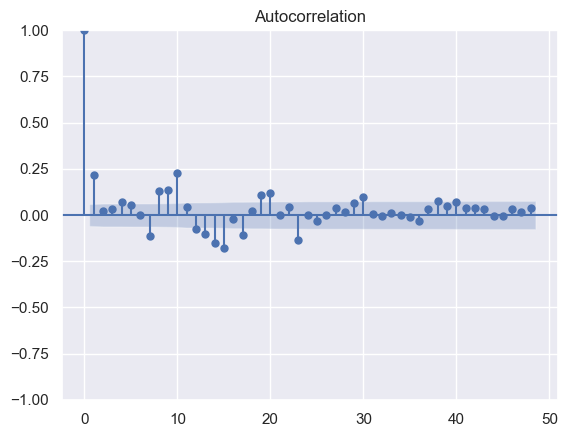

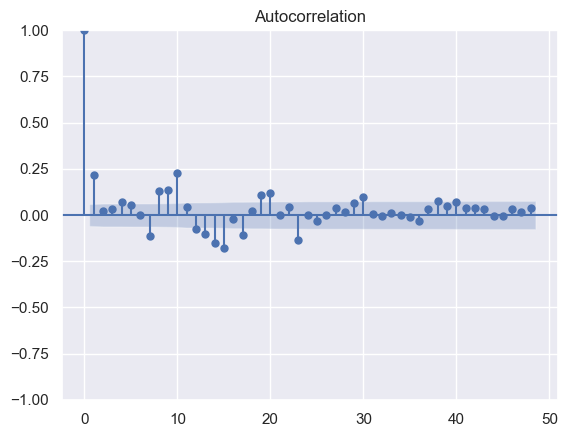

In [30]:
arima2015day=coinbase['2015':].resample('D').mean().fillna(method='ffill')['Close']

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(arima2015day.diff().dropna(), lags= 48, alpha=0.05)

So what does this graph represent? If you observe the autocorrelation value for the present value with itself is 1.0(since current value is totally dependent on current value) and then the correlation goes on decreasing. Intutively, this plot gives you a good guess of the window size to consider for predicting todays bitcoin value.

# Training & Testing

## Model 1: RANDOM FOREST :|

Though many financial analysts and domain experts would argue why random forests for a time series data?? We were performing this project as a part of Machine Learning course and wanted to evaluate its performance over other tradtional models.

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
coinbase

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,PriceClose2D,Year,Month,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-01 00:33:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
2014-12-01 00:34:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
2014-12-01 00:35:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
2014-12-01 00:36:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
2014-12-01 00:37:00,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,300.00,2014,12,...,1,0,335,False,True,False,False,False,False,1.417394e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-07 18:32:00,16349.00,16349.00,16329.00,16329.00,4.303270,70338.446619,16345.349090,16174.23,2018,1,...,7,6,7,False,False,False,False,False,False,1.515350e+09
2018-01-07 18:33:00,16329.01,16329.01,16300.00,16302.85,8.183248,133574.283340,16322.892267,16174.22,2018,1,...,7,6,7,False,False,False,False,False,False,1.515350e+09
2018-01-07 18:34:00,16302.84,16302.84,16279.74,16279.74,7.083056,115426.384420,16296.128527,16174.21,2018,1,...,7,6,7,False,False,False,False,False,False,1.515350e+09


The important thing to note for time series data is you # CANNOT shuffle the data around as you will loose all the temporal patterns. Make sure to shuffle=false

In [32]:
from sklearn.model_selection import train_test_split
trainColumns=['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price', 'Month', 'Week', 'Day',
       'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start',
       'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
predictColumn='PriceClose2D'
X=coinbase[trainColumns]
y=coinbase[predictColumn]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10,shuffle=False)

In [33]:
train_error=[]
test_error=[]
minDepth=20
maxDepth=40
models=[]
for depth in range(minDepth,maxDepth,5):
    regr=RandomForestRegressor(max_depth=depth, random_state=0,n_estimators=5,verbose=2)
    regr.fit(X_train, y_train)
    models.append(regr)
    tr_error=math.sqrt(mean_squared_error(regr.predict(X_train),y_train))
    te_error=math.sqrt(mean_squared_error(regr.predict(X_test),y_test))
    test_error.append(tr_error)
    train_error.append(te_error)
    print (depth,tr_error,te_error)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   50.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


20 4.657279640891137 6369.506613027702


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


25 4.012775600613368 6368.654213519618


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.5s remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


30 3.852380995818222 6373.337580578217


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.2s remaining:    0.0s


building tree 2 of 5
building tree 3 of 5
building tree 4 of 5
building tree 5 of 5


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.3s finished


35 3.820660838623674 6374.10942696613


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


In [34]:
train_error

[6369.506613027702, 6368.654213519618, 6373.337580578217, 6374.10942696613]

Let's plot the curve and see the confusion matrix

2833650

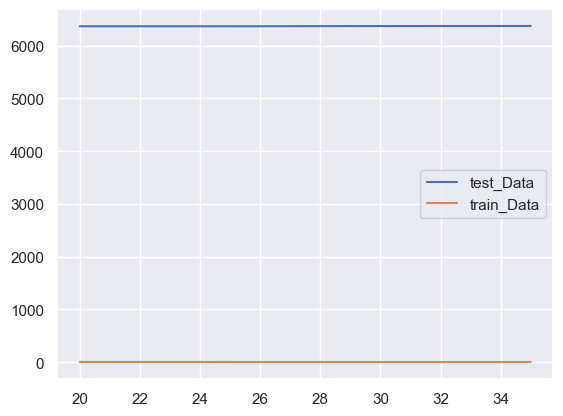

In [35]:
from sklearn.metrics import confusion_matrix
# print(confusion_matrix(models[2].predict(X_test), y_test))
train_plot=pd.DataFrame(train_error,index=range(20,40,5),columns=["test_Data"])
test_plot=pd.DataFrame(test_error,index=range(20,40,5),columns=["train_Data"])
plotdata=pd.concat([train_plot,test_plot],axis=1)
plotdata.plot()
X_test.size

As you can see the training error and test error are apart and as we increase the depth the model tends to overfit. (Expected)

In [36]:
y_test.head()

Date
2017-09-20 11:52:00    3990.59
2017-09-20 11:53:00    3990.59
2017-09-20 11:54:00    3995.06
2017-09-20 11:55:00    3997.58
2017-09-20 11:56:00    3998.57
Name: PriceClose2D, dtype: float64

In [37]:
# from sklearn.metrics import mean_squared_error
# print('testing error',mean_squared_error(regr.predict(X_test),y_test))
# print('training error',mean_squared_error(regr.predict(X_train),y_train))

## Model 2: Recurrent Neural Networks with LSTM and GRU (Seq to Seq) :0

#### Bitcoin2015Daily => Contains all the prices aggregated by day.

In [38]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,GRU
from sklearn.preprocessing import MinMaxScaler,RobustScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from pandas import Series

data=pd.read_csv('Bitcoin2015Daily.csv')
data.head(3)

,Date,Open,Close,High,Low,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2015-01-01,345.0,340.0,345.0,340.0,0.0,0.0,342.5
1,2015-01-02,345.0,340.0,345.0,340.0,0.0,0.0,342.5
2,2015-01-03,345.0,340.0,345.0,340.0,0.0,0.0,342.5


In [39]:
# Prepare data. Set date as index and choose closing price as target.
data=data.set_index(pd.DatetimeIndex(data['Date']))['Close']
data.head(3)

Date
2015-01-01    340.0
2015-01-02    340.0
2015-01-03    340.0
Name: Close, dtype: float64

In [40]:
# make the signal stationary -- subtract the previous value from the current value (Technical jargon: First order difference)
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [41]:
look_back=3
#data=difference(data,look_back)

In [42]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        #takes 
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [43]:
# fix random seed for reproducibility
numpy.random.seed(0)

# load the dataset
dataframe = data
dataset = dataframe.values
dataset = dataset.astype('float64').reshape(-1, 1)
dataset

array([[  340.  ],
       [  340.  ],
       [  340.  ],
       ...,
       [16550.02],
       [16635.31],
       [16266.06]])

In [44]:
# normalize the dataset
scaler = MinMaxScaler()
#scaler=RobustScaler()
#scaler=StandardScaler()
dataset = scaler.fit_transform(dataset)
dataset

array([[0.00988583],
       [0.00988583],
       [0.00988583],
       ...,
       [0.85330463],
       [0.85774233],
       [0.83852999]])

In [45]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

739 364


In [46]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(len(trainX), len(testX))


735 360


In [47]:
# trainX

In [48]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [49]:
# testX

In [50]:
# create and fit the LSTM network
from keras.layers import Activation, Dense,Dropout
model = Sequential()

model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
#model.add(LSTM(256, return_sequences=True,input_shape=(1, look_back)))
model.add(LSTM(256))
#model.add(LSTM(100, input_shape=(1, look_back)))

model.add(Dense(1))

In [51]:
import keras
from keras import optimizers

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, verbose=1,shuffle=False,batch_size=50)

Epoch 1/50
15/15 [==============================] - 3s 6ms/step - loss: 3.3415e-05
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 4.8547e-04
Epoch 3/50
15/15 [==============================] - 0s 7ms/step - loss: 8.7393e-05
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 1.7436e-04
Epoch 5/50
15/15 [==============================] - 0s 5ms/step - loss: 1.1437e-04
Epoch 6/50
15/15 [==============================] - 0s 5ms/step - loss: 1.2203e-04
Epoch 7/50
15/15 [==============================] - 0s 5ms/step - loss: 1.0580e-04
Epoch 8/50
15/15 [==============================] - 0s 5ms/step - loss: 9.1606e-05
Epoch 9/50
15/15 [==============================] - 0s 5ms/step - loss: 7.5145e-05
Epoch 10/50
15/15 [==============================] - 0s 5ms/step - loss: 5.1899e-05
Epoch 11/50
15/15 [==============================] - 0s 5ms/step - loss: 2.8266e-05
Epoch 12/50
15/15 [==============================] - 0s 5ms/step - loss: 8.9846e-06
E

In [52]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [53]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [54]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 19.83 RMSE
Test Score: 570.53 RMSE


In [55]:
predictions = numpy.empty_like(dataset)
predictions[:, :] = numpy.nan
predictions[look_back:len(trainPredict)+look_back, :] = trainPredict
predictions[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#data=pd.DataFrame(numpy.concatenate((trainPredict[0:len(trainPredict)-look_back-1],testPredict[0:len(testPredict)-look_back-1])),columns=["predicted"])
#print('one',data.count())
#print('two',dataframe.count())
predictionsDF=pd.DataFrame(predictions,columns=["predicted"],index=dataframe.index)
ans=pd.concat([dataframe,predictionsDF],axis=1)
print( ans,[look_back,trainScore,testScore])


               Close     predicted
Date                              
2015-01-01    340.00           NaN
2015-01-02    340.00           NaN
2015-01-03    340.00           NaN
2015-01-04    340.00    336.613922
2015-01-05    340.00    336.613922
...              ...           ...
2018-01-03  14986.76  13404.695312
2018-01-04  14938.79  13813.471680
2018-01-05  16550.02  14288.621094
2018-01-06  16635.31  14716.493164
2018-01-07  16266.06           NaN

[1103 rows x 2 columns] [3, 19.832386331414433, 570.5267779114859]


Let's plot and compare the prices predicted and actual price.

<AxesSubplot:xlabel='Date'>

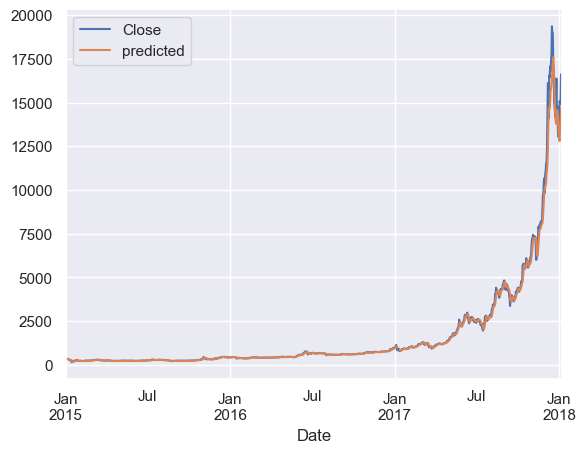

In [56]:
ans.plot()

<ipython-input-57-4067f2678e90>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ans['2017-12'].plot()


<AxesSubplot:xlabel='Date'>

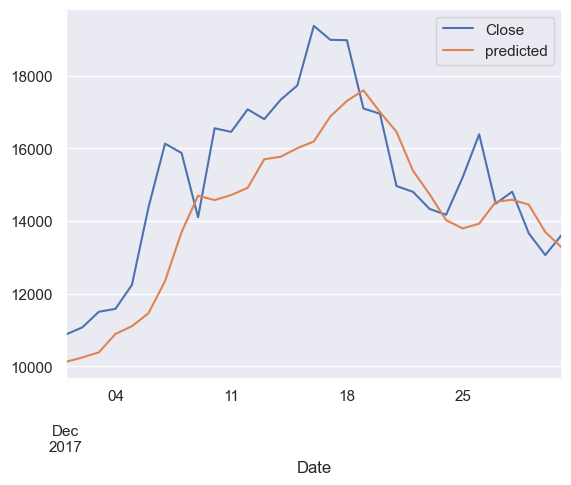

In [57]:
ans['2017-12'].plot()

The above graph is bitcoin prediction during the great bitcoin fall in 2017 December. As you can see its pretty close. 

<ipython-input-58-2aaf386c1058>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ans['2017-11'].plot()


<AxesSubplot:xlabel='Date'>

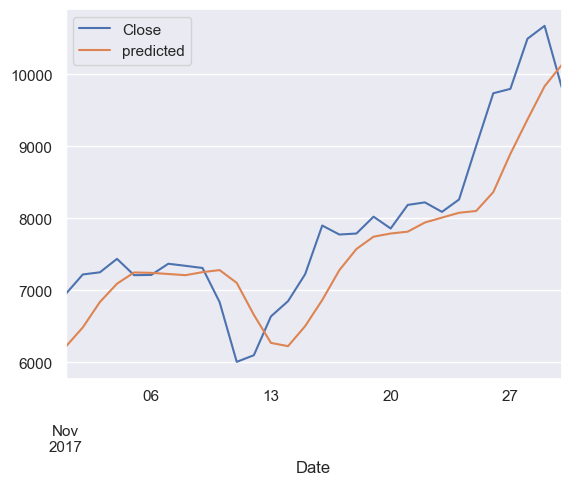

In [58]:
ans['2017-11'].plot() 

<ipython-input-59-05412888f0a6>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ans['2017-12'].plot()


<AxesSubplot:xlabel='Date'>

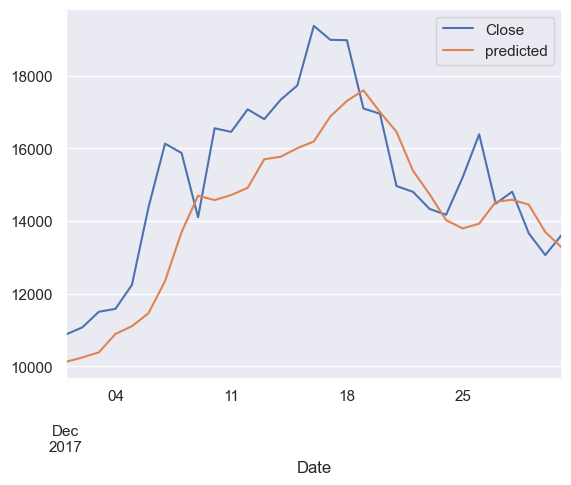

In [59]:
ans['2017-12'].plot() 

<ipython-input-60-d26fce375b4e>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ans['2018-01'].plot()


<AxesSubplot:xlabel='Date'>

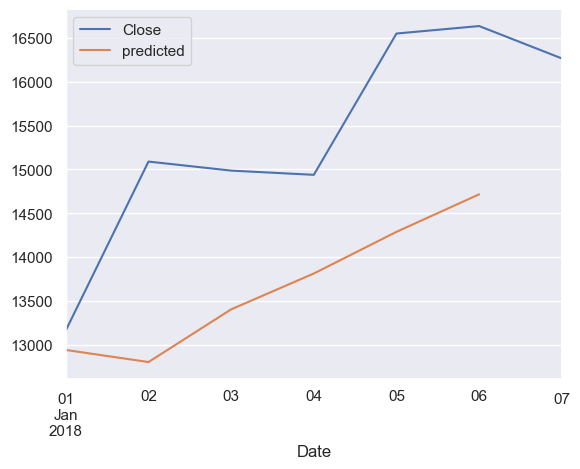

In [60]:
ans['2018-01'].plot() 

<ipython-input-61-23e9907c9217>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  ans['2017-08'].plot()


<AxesSubplot:xlabel='Date'>

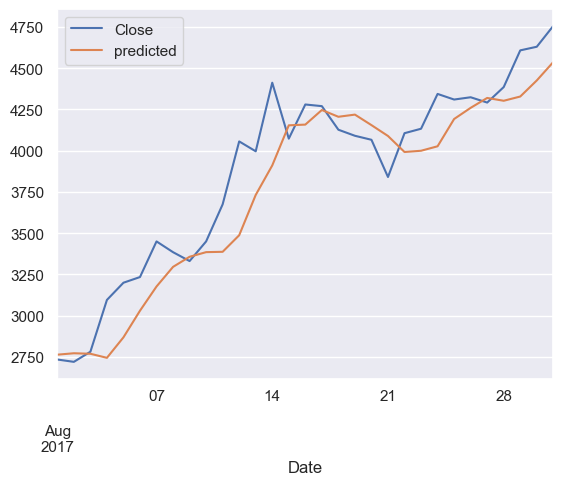

In [61]:
ans['2017-08'].plot() 

# Model 3: ARIMA MODEL :)

Autoregressive Integrated Moving Average Model. An ARIMA model is a class of statistical models for analyzing and forecasting time series data. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts

Note: The accuracy of Arima Model here is better as we are training for 50% of data and then while testing we are training the whole data set again + the any new instance. So on a high level the model predicts price of next day given last few days price. 

In [62]:
arima2015hour=coinbase['2015':].resample('D').mean().fillna(method='ffill')['Close']

<ipython-input-62-9e0c7cd310a2>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  arima2015hour=coinbase['2015':].resample('D').mean().fillna(method='ffill')['Close']


In [63]:
arima2015hour

Date
2015-01-07      302.148426
2015-01-08      288.934674
2015-01-09      288.934674
2015-01-10      288.934674
2015-01-11      288.934674
                  ...     
2018-01-03    15033.472139
2018-01-04    14825.769069
2018-01-05    16150.067569
2018-01-06    16691.451653
2018-01-07    16440.150027
Freq: D, Name: Close, Length: 1097, dtype: float64

What we are intrested in is not the price but the trend and finding if there is any hidden pattern in ups and down of bitcoin price. We therefore first take the difference of each Xt with its previous price to signify if the price has increased or decreased and see if there is any autocorrelation and find the approximate lagging. We find this graph to be indicating a good lag to be around 30.

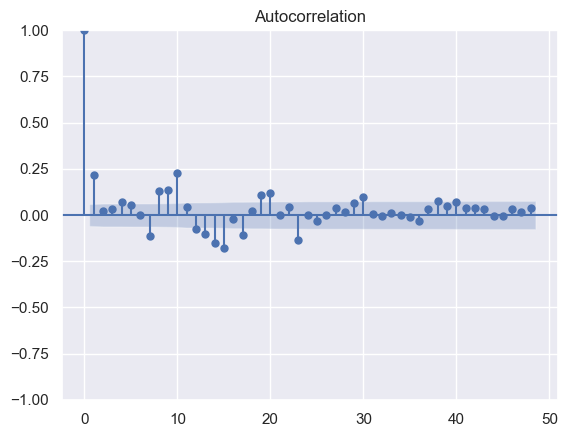

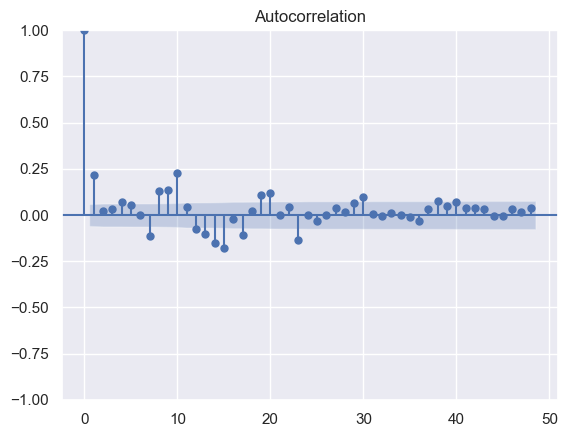

In [64]:
from statsmodels.graphics.tsaplots import plot_acf
#hourarim=arima2015hour.resample('H').mean()['Close']
plot_acf(arima2015hour.diff().dropna(), lags= 48, alpha=0.05)
#arima2015hour['Close'].pct_change().autocorr()
#dayarima.diff()
#arima2015hour.dropna().diff().plot()

Often financial stock market analysts use some statistical measure to see if the prices are predictable or not. (Technically speaking if the prices are random walk or even if its white noise.) Test TO find if the data is random walk. Which is Not. 

In [65]:
from statsmodels.tsa.stattools import adfuller
adfuller(arima2015hour)[1]

0.9987867392172342

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
train,test = train_test_split(arima2015hour,test_size=0.24,shuffle=False)
print(train)

Date
2015-01-07     302.148426
2015-01-08     288.934674
2015-01-09     288.934674
2015-01-10     288.934674
2015-01-11     288.934674
                 ...     
2017-04-14    1181.642604
2017-04-15    1181.556806
2017-04-16    1181.432667
2017-04-17    1183.139410
2017-04-18    1200.347361
Freq: D, Name: Close, Length: 833, dtype: float64


In [67]:
# from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(arima2015hour, order=(4,4,0))
result = mod.fit()

history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history,order=(5,1,0))
    model_fit = mod.fit()
    yhat = model_fit.forecast()
    yhat_p = model_fit.predict(start=len(history), end=len(history))[0]
    predictions.append(yhat_p)
    # observation
    obs = test[i] 
    history.append(obs)
    print(str(yhat_p)+' '+' '+ str(history[-4:])+' '+str(obs)+' '+str(i)+' ')

1233.5311977089639  [1181.4326666666666, 1183.1394097222221, 1200.347361111111, 1203.6566319444444] 1203.6566319444444 0 
1196.4491797395754  [1183.1394097222221, 1200.347361111111, 1203.6566319444444, 1229.8685] 1229.8685 1 
1264.5372030348337  [1200.347361111111, 1203.6566319444444, 1229.8685, 1248.6709097222224] 1248.6709097222224 2 
1273.6717663141067  [1203.6566319444444, 1229.8685, 1248.6709097222224, 1244.4463333333333] 1244.4463333333333 3 
1229.5095768231517  [1229.8685, 1248.6709097222224, 1244.4463333333333, 1248.4556458333334] 1248.4556458333334 4 
1239.2875211576163  [1248.6709097222224, 1244.4463333333333, 1248.4556458333334, 1254.437798611111] 1254.437798611111 5 
1255.9847788294128  [1244.4463333333333, 1248.4556458333334, 1254.437798611111, 1277.1488333333334] 1277.1488333333334 6 
1300.1981485471072  [1248.4556458333334, 1254.437798611111, 1277.1488333333334, 1298.5008819444445] 1298.5008819444445 7 
1339.181061742929  [1254.437798611111, 1277.1488333333334, 1298.5008

2685.1524163235895  [2408.231861111111, 2541.074326388889, 2554.110701388889, 2498.9669375000003] 2498.9669375000003 72 
2439.337101813411  [2541.074326388889, 2554.110701388889, 2498.9669375000003, 2452.1534097222225] 2452.1534097222225 73 
2339.848494021357  [2554.110701388889, 2498.9669375000003, 2452.1534097222225, 2469.5617847222225] 2469.5617847222225 74 
2398.320487287905  [2498.9669375000003, 2452.1534097222225, 2469.5617847222225, 2534.098986111111] 2534.098986111111 75 
2607.715099902971  [2452.1534097222225, 2469.5617847222225, 2534.098986111111, 2598.409180555556] 2598.409180555556 76 
2784.766833200126  [2469.5617847222225, 2534.098986111111, 2598.409180555556, 2586.3999444444444] 2586.3999444444444 77 
2598.5718275335657  [2534.098986111111, 2598.409180555556, 2586.3999444444444, 2598.2301736111112] 2598.2301736111112 78 
2566.3508099847936  [2598.409180555556, 2586.3999444444444, 2598.2301736111112, 2533.6880694444444] 2533.6880694444444 79 
2378.782151793359  [2586.3999

4105.669851111961  [4600.271472222222, 4453.546888888888, 4329.529534722223, 4250.614541666667] 4250.614541666667 144 
4005.7152862728967  [4453.546888888888, 4329.529534722223, 4250.614541666667, 4212.8381875000005] 4212.8381875000005 145 
4152.872529729212  [4329.529534722223, 4250.614541666667, 4212.8381875000005, 4229.4228125] 4229.4228125 146 
4421.861438942625  [4250.614541666667, 4212.8381875000005, 4229.4228125, 3899.4992291666663] 3899.4992291666663 147 
3533.2279884602553  [4212.8381875000005, 4229.4228125, 3899.4992291666663, 3545.2712430555553] 3545.2712430555553 148 
2987.954169534215  [4229.4228125, 3899.4992291666663, 3545.2712430555553, 3495.2340694444442] 3495.2340694444442 149 
3394.5817141655707  [3899.4992291666663, 3545.2712430555553, 3495.2340694444442, 3756.6529375000005] 3756.6529375000005 150 
4240.261181614286  [3545.2712430555553, 3495.2340694444442, 3756.6529375000005, 3691.706048611111] 3691.706048611111 151 
3843.7368094875237  [3495.2340694444442, 3756.65

8276.954416086804  [7752.3725, 7885.3930625, 8149.793006944445, 8192.566888888889] 8192.566888888889 216 
8331.261826206815  [7885.3930625, 8149.793006944445, 8192.566888888889, 8224.038] 8224.038 217 
8370.585854409303  [8149.793006944445, 8192.566888888889, 8224.038, 8158.045340277778] 8158.045340277778 218 
8014.755332471236  [8192.566888888889, 8224.038, 8158.045340277778, 8221.748743055556] 8221.748743055556 219 
8152.034790344698  [8224.038, 8158.045340277778, 8221.748743055556, 8639.591048611112] 8639.591048611112 220 
9236.281497472404  [8158.045340277778, 8221.748743055556, 8639.591048611112, 9295.825416666667] 9295.825416666667 221 
10403.673898876723  [8221.748743055556, 8639.591048611112, 9295.825416666667, 9696.481555555556] 9696.481555555556 222 
10325.36365546818  [8639.591048611112, 9295.825416666667, 9696.481555555556, 9977.966125] 9977.966125 223 
10232.124058537678  [9295.825416666667, 9696.481555555556, 9977.966125, 10541.490055555556] 10541.490055555556 224 
10957.

In [68]:
resultsall = pd.concat([pd.DataFrame(predictions,index=test.index,columns=['predictions']),test],axis=1)
resultsall.head(3)

,predictions,Close
Date,,
2017-04-19,1233.531198,1203.656632
2017-04-20,1196.449180,1229.868500
2017-04-21,1264.537203,1248.670910


In [69]:
error=math.sqrt(mean_squared_error(test,predictions))
error

695.2002797477246

In [70]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(arima2015hour, order=(4,4,0))
result = mod.fit()

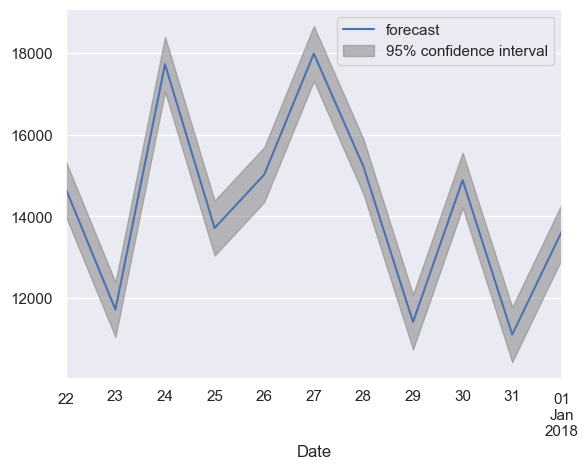

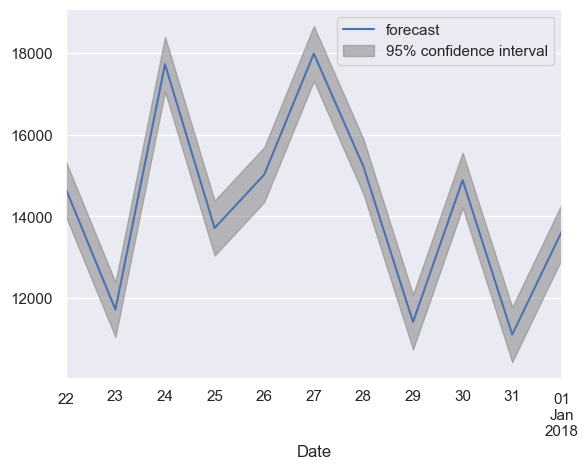

In [71]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(result, start=1080,end=1090)

In [72]:
print(result.summary())
# result.plot_predict()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1097
Model:                 ARIMA(4, 4, 0)   Log Likelihood               -7930.705
Date:                Wed, 10 May 2023   AIC                          15871.409
Time:                        13:49:53   BIC                          15896.393
Sample:                    01-07-2015   HQIC                         15880.863
                         - 01-07-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5567      0.007   -229.176      0.000      -1.570      -1.543
ar.L2         -1.5253      0.011   -135.312      0.000      -1.547      -1.503
ar.L3         -1.0545      0.012    -84.428      0.0

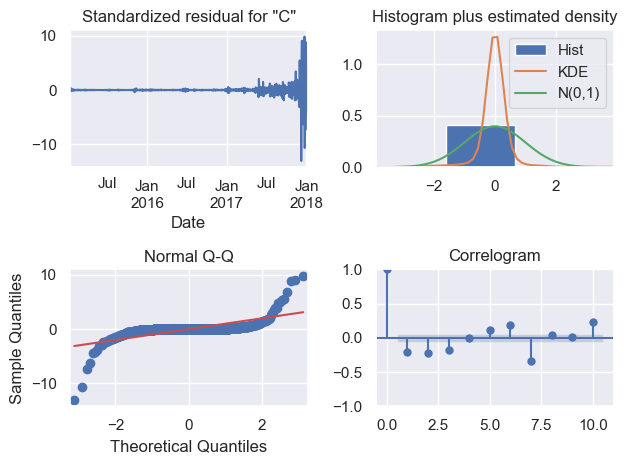

In [74]:
# result.plot_predict(start=1060, end=1090)
result.plot_diagnostics()
plt.tight_layout()
plt.show()


## Conclusions

ARIMA performs well for next days predictions but performs poor for longer terms like given last few days price predict next 5-7 days prices. RNN perform consistently upto 6 days. Random Forest usually perform poorly on validation set and unseen patterns. RNN and ARIMA model perform well but fail to predict the hype or the unusal spike caused by rumors or fake news. One can use sentiments from twitter to incorporate these changes.